In [7]:
from autocnet_server.graph.graph import NetworkCandidateGraph
%pylab inline

from autocnet.transformation.trifocal import Trifocal
from autocnet.transformation.fundamental_matrix import compute_epipolar_lines
from autocnet.utils.utils import make_homogeneous
from autocnet.camera.camera import estimated_camera_from_f



Populating the interactive namespace from numpy and matplotlib


In [2]:
ncg = NetworkCandidateGraph.from_database()

In [3]:
#519

In [3]:
ed1 = ncg.edges[(594,616)]['data']
ed1.compute_fundamental_matrix(method='ransac', reproj_threshold=20)

In [4]:
ed2 = ncg.edges[(594,619)]['data']
ed2.compute_fundamental_matrix(method='ransac', reproj_threshold=20)

In [5]:
ed3 = ncg.edges[(616,619)]['data']
ed3.compute_fundamental_matrix(method='ransac', reproj_threshold=20)

In [76]:
f21 = ed1['fundamental_matrix']
f31 = ed2['fundamental_matrix']
f32 = ed3['fundamental_matrix']

## Projective Matrix from Fundamental Matrix

In [373]:
import numpy as np

def p_from_f(f):
    u,s,v = np.linalg.svd(f)
    #e = u(:,3);
    e = u[:,2]
    p = np.empty((3,4))
    y = np.array([[0,e[2],-e[1]],
                   [-e[2],0,e[0]],
                  [e[1],-e[0],0]])
    p[:,:3] = -y.dot(f)
    p[:,3] = e
    return p

# Compute the camera matrix from the fundamental matrices
p2 = p_from_f(ed2['fundamental_matrix'])
p3 = p_from_f(ed3['fundamental_matrix'])

In [372]:
p_from_f(f21)

array([[ -1.32967796e-02,   1.66434699e-03,  -9.92053171e-01,
         -1.25819082e-01],
       [  1.68638999e-03,  -2.11084057e-04,   1.25819342e-01,
         -9.92053203e-01],
       [  4.36325343e-08,   2.53394023e-07,  -1.35570113e-02,
         -1.93244935e-05]])

## Match Correction using Geometric Constraint

In [9]:
import scipy
from scipy import linalg, matrix
def null(A, eps=1e-15):
    u, s, vh = scipy.linalg.svd(A)
    null_mask = (s <= eps)
    null_space = scipy.compress(null_mask, vh, axis=0)
    return -scipy.transpose(null_space)

def correct_matches(x1, x2, f):
    x1hat = np.zeros(x1.shape)
    x2hat = np.zeros(x2.shape)
    t1 = np.eye(3)
    t2 = np.eye(3)
    for i in range(x1.shape[0]):
        t1[:,2][:2] = (-x1[i,:2])
        t2[:,2][:2] = (-x2[i,:2])
        fnew = np.linalg.inv(t2).T.dot(f.dot(np.linalg.inv(t1)))
        e1 = null(f)
        e2 = null(f.T)
        e1 = (e1 / math.sqrt(e1[0]**2 + e1[1]**2)).flatten()
        e2 = (e2 / math.sqrt(e1[0]**2 + e2[1]**2)).flatten()
        r1 = np.eye(3)
        r1[0, :2] = e1[:2] 
        r1[1, :2] = [-e1[1], e1[0]]
        r2 = np.eye(3)
        r2[0, :2] = e2[:2]
        r2[1, :2] = [-e2[1], e2[0]]
        fnew = r2.dot(fnew.dot(r1.T))
        f1 = e1[2] 
        f2 = e2[2]
        a = fnew[1,1]
        b = fnew[1,2]
        c = fnew[2,1]
        d = fnew[2,2]
        coeff0 = b**2*c*d-a*d**2*b
        coeff1 = -a**2*d**2+b**2*c**2+f2**4*d**4+b**4+2*b**2*f2**2*d**2 
        coeff2 = 4*b**2*f2**2*c*d-2*a*d**2*f1**2*b+2*b**2*c*f1**2*d+4*f2**4*c*d**3+4*a*b**3-a**2*d*c+b*c**2*a+4*a*b*f2**2*d**2 
        coeff3 = 6*a**2*b**2-2*a**2*d**2*f1**2+6*f2**4*c**2*d**2+2*b**2*f2**2*c**2+2*b**2*c**2*f1**2+8*a*b*f2**2*c*d+2*a**2*f2**2*d**2
        coeff4 = 4*f2**4*c**3*d-a*d**2*f1**4*b+4*a**2*f2**2*c*d+4*a*b*f2**2*c**2+2*b*c**2*f1**2*a+4*a**3*b+b**2*c*f1**4*d-2*a**2*d*f1**2*c
        coeff5 = (a**2+f2**2*c**2)**2-(a*d-b*c)*f1**4*b*c-(a*d-b*c)*f1**4*a*d
        coeff6 = (-a*d+b*c)*f1**4*a*c
        
        ts = np.roots(np.array([coeff6, coeff5, coeff4, coeff3, coeff2, coeff1, coeff0]))
        ts = np.real(ts)
        min_cost = np.inf
        for j in range(len(ts)):
            t = ts[j]
            cost = t**2 / (1+f1**2*t**2) + (c*t+d)**2/( (a*t+b)**2 + f2**2*(c*t+d)**2 )
            if cost < min_cost:
                min_cost = cost
                best_t = t
        asym_cost = 1 / f1**2 + c**2/(a**2 + f2**2*c**2)
        l1 = np.array([best_t*f1, 1, -best_t])
        l2 = np.array([-f2*(c*best_t+d), a*best_t+b, c*best_t+d])

        x1hat[i] = np.array([-l1[0]*l1[2], -l1[1]*l1[2], l1[0]**2+l1[1]**2])
        x2hat[i] = np.array([-l2[0]*l2[2], -l2[1]*l2[2], l2[0]**2+l2[1]**2])
        x1hat[i] = np.linalg.inv(t1).dot(r1.T.dot(x1hat[i]))
        x2hat[i] = np.linalg.inv(t2).dot(r2.T.dot(x2hat[i]))
    x1hat[:,0] /= x1hat[:,2]
    x1hat[:,1] /= x1hat[:,2]
    x1hat[:,2] /= x1hat[:,2]
    
    x2hat[:,0] /= x2hat[:,2]
    x2hat[:,1] /= x2hat[:,2]
    x2hat[:,2] /= x2hat[:,2]
    return x1hat, x2hat
x1 = make_homogeneous(ed1.matches[['source_x', 'source_y']].values)
x2 = make_homogeneous(ed1.matches[['destination_x', 'destination_y']].values)
x1hat, x2hat = correct_matches(x1, x2, f21)

## Epipolar Transfer

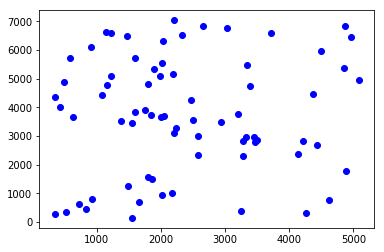

In [217]:
x1 = make_homogeneous(ed1.matches[['source_x', 'source_y']].values)
x2 = make_homogeneous(ed1.matches[['destination_x', 'destination_y']].values)

x3 = np.empty(x1.shape)

# 15.3.1 Point transfer using the fundamental matrices
"""
x1 : correspondences in image 1
x2 : correspondences in image 2
f31 : fundamental matrix for the 'second edge' (image 1 to image 3)
f32 : fundmanetal matrix for the 'third edge' (image 2 to image 3)

This then transfers the points from the first edge (image1 to image2) 
into image 3.
"""

x1hat, x2hat = correct_matches(x1, x2, )

for i in range(x1.shape[0]):    
    a = x1[i]
    b = x2[i]
    x3[i] = np.cross((f31.dot(a)), (f32.dot(b)))
x3[:,0] /= x3[:,2]
x3[:,1] /= x3[:,2]
plot(x3[:,0], x3[:,1], 'bo')

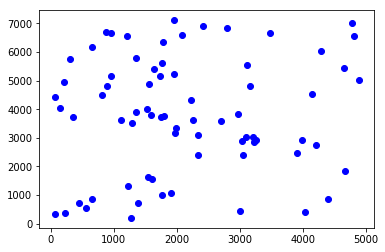

In [84]:
plot(x1[:,0], x1[:,1], 'bo')

## Visualization

In [ ]:
def apply_plot(r, a, b, c):
    a = a.read_array(pixels=(int(r.source_x-50), int(r.source_y-50),100,100))
    b = b.read_array(pixels=(int(r.destination_x-50), int(r.destination_y-50), 100,100))
    try:
        c = c.read_array(pixels=(int(r.c_x-50), int(r.c_y-50), 100, 100)) 
    except:
        c = np.zeros((100,100))
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    ax1.imshow(a, cmap='Greys')
    ax2.imshow(b, cmap='Greys')
    ax3.imshow(c, cmap='Greys')

    return fig

a = ed1.source.geodata
b = ed1.destination.geodata
c = ed2.destination.geodata
tri_matches = ed1.matches
tri_matches['c_x'] = x3[:,0]
tri_matches['c_y'] = x3[:,1]
figs = tri_matches.apply(apply_plot, args=(a,b,c), axis=1)
figs = None

## Trifocal Transfer Coded to use the Trifocal Object

In [58]:
f21 = ed1['fundamental_matrix'] # 594 to 616
f31 = ed2['fundamental_matrix'] # 594 to 619
f32 = ed3['fundamental_matrix'] # 616 to 619

p1 = estimated_camera_from_f(f21)
p2 = estimated_camera_from_f(f31)
p3 = estimated_camera_from_f(f32)

T = Trifocal(p1, p2)

x1 = make_homogeneous(ed1.matches[['source_x', 'source_y']].values)
x2 = make_homogeneous(ed1.matches[['destination_x', 'destination_y']].values)
f21, f31 = T.getFundamentalMat()
x1hat, x2hat = correct_matches(x1, x2, f21)

# This should be for all pts
#le2 = np.sum(f21 * x1hat[:,np.newaxis], axis=2)

# Compute the line in 2 and the perpindicular
#l2 = np.empty(le2.shape)
#l2[:,0] = le2[:,1] * x2hat[:,2]
#l2[:,1] = -le2[:,0] * x2hat[:,2]
#l2[:,2] = -x2[:,0] * le2[:,1] + x2hat[:,1] * le2[:,0]

# Transfer the points to view 3
x3 = np.empty(x1.shape)
for i in range(x1.shape[0]):
    x3[i] = (T.T[0].dot(x1hat[i, 0]) +\
             T.T[1].dot(x1hat[i, 1]) +\
             T.T[2].dot(x1hat[i, 2])).T.dot(l2[i])
x3[:,0] /= x3[:,2]
x3[:,1] /= x3[:,2]
x3[:,2] /= x3[:,2]

In [99]:
T * [1,1,1]

TypeError: can't multiply sequence by non-int of type 'Trifocal'

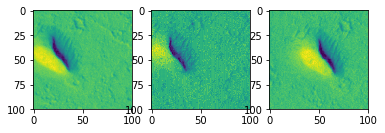

In [96]:
i = 1
ap = x1hat[i]
bp = x2hat[i]
res = x3[i]
nx = int(res[0] - 50)
ny = int(res[1] - 50)
nx = 2850
ny = 3450
a = ed1.source.geodata.read_array(pixels=(int(ap[0]-50), int(ap[1]-50),100,100))
b = ed1.destination.geodata.read_array(pixels=(int(bp[0]-50), int(bp[1]-50), 100,100))
c = ed2.destination.geodata.read_array(pixels=(nx, ny, 100,100))
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(a)
ax2.imshow(b)
ax3.imshow(c)

## Trifocal Point Transfer II

[  2.19080612e+03   3.86529818e+03   1.00000000e+00]
2140 3815


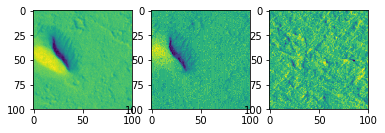

In [23]:
# 594 - 1st
# 616 - 2nd
# 619 - 3rd

of21 = ed1['fundamental_matrix'] # 594 to 616
of31 = ed2['fundamental_matrix'] # 594 to 619
f32 = ed3['fundamental_matrix'] # 616 to 619

p1 = estimated_camera_from_f(of21)
p2 = estimated_camera_from_f(of31)
p3 = estimated_camera_from_f(f32)

T = Trifocal(p1, p2)

x1 = make_homogeneous(ed1.matches[['source_x', 'source_y']].values)
x2 = make_homogeneous(ed1.matches[['destination_x', 'destination_y']].values)

f21, f31 = T.getFundamentalMat()
np.testing.assert_almost_equal(of21, f21)
np.testing.assert_almost_equal(of31, f31)
x1hat, x2hat = correct_matches(x1, x2, f21)

i = 1

# This should be for all pts
le2 = np.sum(f21 * x1hat[:,np.newaxis], axis=2)

# Compute the line in 2 and the perpindicular
l2 = np.empty(le2.shape)
l2[:,0] = le2[:,1] * x2hat[:,2]
l2[:,1] = -le2[:,0] * x2hat[:,2]
l2[:,2] = -x2[:,0] * le2[:,1] + x2hat[:,1] * le2[:,0]

res = T.pl_(x1hat[i], l2[i])
#res = point_transfer(T.T, x1hat[i], x2hat[i])
res[0] /= res[2]
res[1] /= res[2]
res[2] /= res[2]
print(res)

ap = x1hat[i]
bp = x2hat[i]
nx = int(res[0] - 50)
ny = int(res[1] - 50)
print(nx, ny)
a = ed1.source.geodata.read_array(pixels=(int(ap[0]-50), int(ap[1]-50),100,100))
b = ed1.destination.geodata.read_array(pixels=(int(bp[0]-50), int(bp[1]-50), 100,100))
c = ed2.destination.geodata.read_array(pixels=(nx, ny, 100,100))
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(a)
ax2.imshow(b)
ax3.imshow(c)

In [28]:
T.getEpipoles()

(array([ -1.25819082e-01,  -9.92053203e-01,  -1.93244935e-05]),
 array([ -4.23388114e-01,  -9.05948373e-01,  -2.25390101e-04]))

## Trifocal Transfer using the Trifocal Object

[[  4.57197446e+02   7.18987703e+02   1.00000000e+00]
 [  1.74900137e+03   3.74124853e+03   1.00000000e+00]
 [  1.53433629e+03   1.62535857e+03   1.00000000e+00]
 [  1.55067823e+03   4.89374258e+03   1.00000000e+00]
 [  1.77063610e+03   5.61556105e+03   1.00000000e+00]
 [  4.29366525e+03   6.03572365e+03   1.00000000e+00]
 [  2.96266762e+03   3.84290735e+03   1.00000000e+00]
 [  2.07193274e+02   4.94936249e+03   1.00000000e+00]
 [  1.72544439e+03   5.17281738e+03   1.00000000e+00]
 [  2.79685836e+03   6.83839800e+03   1.00000000e+00]
 [  4.40053443e+03   8.64466438e+02   1.00000000e+00]
 [  3.10608572e+03   5.53189191e+03   1.00000000e+00]
 [  1.96216784e+03   3.18658452e+03   1.00000000e+00]
 [  1.38898242e+03   7.33604980e+02   1.00000000e+00]
 [  3.98972033e+03   2.90994155e+03   1.00000000e+00]
 [  1.77820761e+03   6.36357316e+03   1.00000000e+00]
 [  1.22257185e+03   1.31858865e+03   1.00000000e+00]
 [  4.88864404e+03   5.03592187e+03   1.00000000e+00]
 [  6.54076717e+02   8.48274

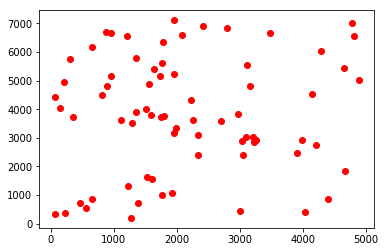

In [157]:
# Compute the camera matrix from the fundamental matrices
of21 = ed1['fundamental_matrix'] # 594 to 616
of31 = ed2['fundamental_matrix'] # 594 to 619
f32 = ed3['fundamental_matrix'] # 616 to 619

p1 = estimated_camera_from_f(of21)
p2 = estimated_camera_from_f(of31)
p3 = estimated_camera_from_f(f32)

# Compute the trifocal tensor
T = Trifocal(p2, p3)
#f21, f31 = T.getFundamentalMat()
#np.testing.assert_almost_equal(of21, f21)
#np.testing.assert_almost_equal(of31, f31)

x1 = make_homogeneous(ed1.matches[['source_x', 'source_y']].values)
x2 = make_homogeneous(ed1.matches[['destination_x', 'destination_y']].values)
x1hat, x2hat = correct_matches(x1, x2, f21)

# This should be for all pts
le2 = np.sum(f21 * x1hat[:,np.newaxis], axis=2)

# Compute the line in 2 and the perpindicular
l2 = np.empty(le2.shape)
l2[:,0] = le2[:,1] * x2hat[:,2]
l2[:,1] = -le2[:,0] * x2hat[:,2]
l2[:,2] = -x2[:,0] * le2[:,1] + x2hat[:,1] * le2[:,0]

x3 = np.empty(x1.shape)
for i in range(x3.shape[0]):
    #l1 = f21.dot(x1hat[i])
    a = x1hat[i].dot(l2[i].dot(T.T[:,1,2]))
    #a = T.p_l(x2[i], l2[i]) #pt1, line3  2nd image
    #b = T.pl_(x1[i], l2[i]) #pt1, line2 3rd image
    #nx = 2850
    #ny = 3450
    #a[0] /= a[2]
    #a[1] /= a[2]
    #b[0] /= b[2]
    #b[1] /= b[2]

    x3[i] = a
x3[:,0] /= x3[:,2]
x3[:,1] /= x3[:,2]
x3[:,2] /= x3[:,2]
#x3
print(x3)
plot(x3[:,0], x3[:,1], 'ro')

3738 1911


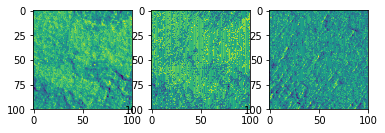

In [132]:
i = 1
res = x3[i]
ap = x1hat[i]
bp = x2hat[i]
nx = int(res[1] - 50)
ny = int(res[0] - 50)
print(nx, ny)
a = ed1.source.geodata.read_array(pixels=(int(ap[0]-50), int(ap[1]-50),100,100))
b = ed1.destination.geodata.read_array(pixels=(int(bp[0]-50), int(bp[1]-50), 100,100))
c = ed2.destination.geodata.read_array(pixels=(nx, ny, 100,100))
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(a)
ax2.imshow(b)
ax3.imshow(c)

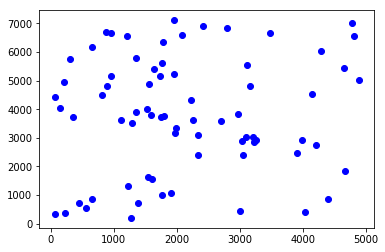

In [130]:
plot(x1[:,0], x1[:,1], 'bo')

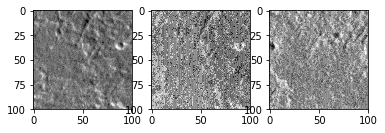

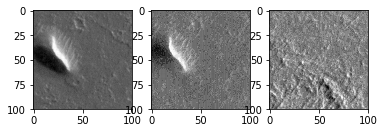

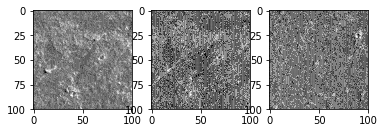

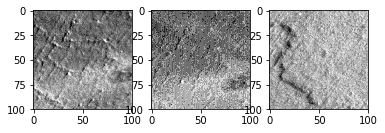

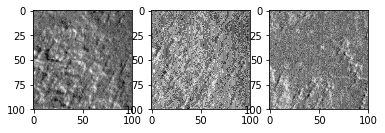

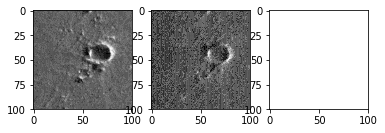

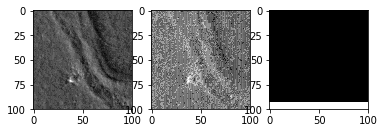

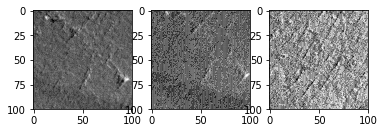

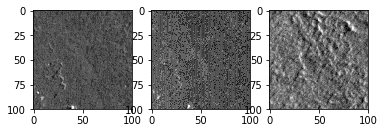

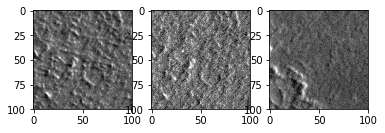

In [379]:
def apply_plot(r, a, b, c):
    a = a.read_array(pixels=(int(r.source_x-50), int(r.source_y-50),100,100))
    b = b.read_array(pixels=(int(r.destination_x-50), int(r.destination_y-50), 100,100))
    try:
        c = c.read_array(pixels=(int(r.c_x-50), int(r.c_y-50), 100,100))
    except:
        c = np.ones((100,100))
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    ax1.imshow(a, cmap='Greys')
    ax2.imshow(b, cmap='Greys')
    ax3.imshow(c, cmap='Greys')
    return fig

a = ed1.source.geodata
b = ed1.destination.geodata
c = ed2.destination.geodata
tmatches = ed1.matches
tmatches['c_x'] = x3[:,0]
tmatches['c_y'] = x3[:,1]
figs = tmatches.head(10).apply(apply_plot, args=(a,b, c), axis=1)
figs = None